# SVM

## Preparing Libraries and Dataset

### Import Libraries

In [1]:
####### Import Libraries
import pandas as pd
import re
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt



### Preprocessing dataset

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [3]:
df = pd.read_csv("/content/learning_outcomes.csv")

df["Learning_Outcome"] = df["Learning_Outcome"].astype(str).apply(clean_text)

X = df["Learning_Outcome"]
y = df["Level"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Training

#### Pipeline

In [5]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

#### Param Tuning

In [6]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [7]:
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],
    "svm__C": [0.1, 1.0, 10.0]
}

#### Training

In [8]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1.0, 10.0], 'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

### Eval

#### Classification-Report Train

In [9]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Best Params: {'svm__C': 10.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.9868932038834951
              precision    recall  f1-score   support

          A2       1.00      1.00      1.00         2
          A3       1.00      1.00      1.00         4
          A4       0.92      0.94      0.93        62
          A5       0.89      1.00      0.94        62
          C1       0.99      1.00      0.99        70
          C2       1.00      0.98      0.99       393
          C3       0.98      0.99      0.99       233
          C4       0.99      0.99      0.99       390
          C5       1.00      0.99      1.00       169
          C6       1.00      0.99      1.00       373
          P2       1.00      1.00      1.00        23
          P3       0.99      0.97      0.98       179
          P4       0.96      1.00      0.98        82
          P5       1.00      1.00      1.00        18

    accuracy                           0.99      2060
   macro avg       0.98  

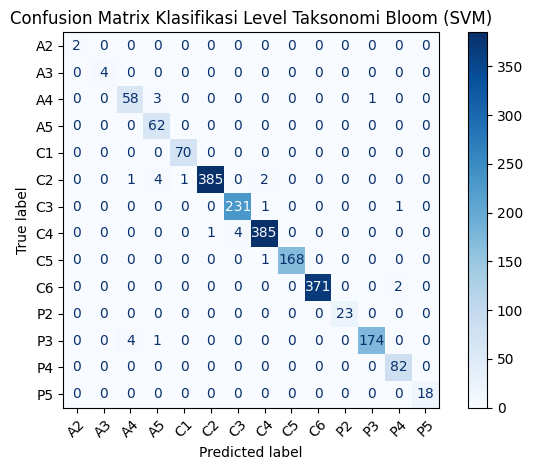

In [10]:
labels = sorted(y_train.unique(), key=lambda x: (x[0], int(x[1:])))
cm = confusion_matrix(
    y_train,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    cmap="Blues",
    values_format="d",
    xticks_rotation=45
)

plt.title("Confusion Matrix Klasifikasi Level Taksonomi Bloom (SVM)")
plt.tight_layout()
plt.show()

#### Classification-Report Val

In [11]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Params: {'svm__C': 10.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8158914728682171
              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         1
          A3       0.00      0.00      0.00         1
          A4       0.86      0.38      0.52        16
          A5       0.64      0.93      0.76        15
          C1       0.80      0.94      0.86        17
          C2       0.90      0.92      0.91        98
          C3       0.82      0.76      0.79        59
          C4       0.87      0.85      0.86        98
          C5       0.70      0.79      0.74        42
          C6       0.86      0.91      0.89        93
          P2       0.67      0.33      0.44         6
          P3       0.70      0.69      0.70        45
          P4       0.71      0.71      0.71        21
          P5       0.50      0.25      0.33         4

    accuracy                           0.82       516
   macro avg       0.65  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


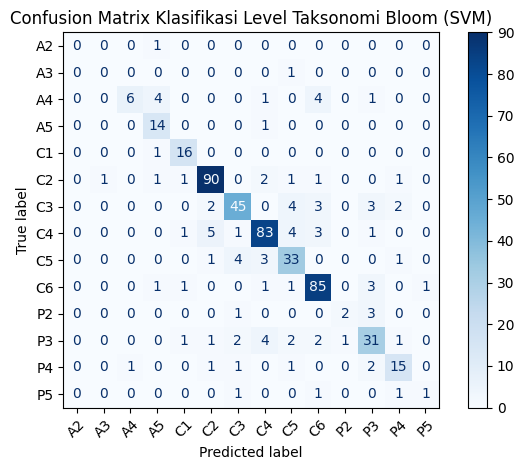

In [12]:
labels = sorted(y_test.unique(), key=lambda x: (x[0], int(x[1:])))
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    cmap="Blues",
    values_format="d",
    xticks_rotation=45
)

plt.title("Confusion Matrix Klasifikasi Level Taksonomi Bloom (SVM)")
plt.tight_layout()
plt.show()

#### Save Model

In [13]:
joblib.dump(best_model, "svm_bloom_level_tuned.pkl")
print("Model saved: svm_bloom_level_tuned.pkl")

Model saved: svm_bloom_level_tuned.pkl


#### Alignment Eval

In [14]:
model = joblib.load("svm_bloom_level_tuned.pkl")
df = pd.read_csv("cpmk_subcpmk_pairs.csv")

In [15]:
df["pred_level_cpmk"] = model.predict(df["cpmk"].astype(str))
df["pred_level_subcpmk"] = model.predict(df["subcpmk"].astype(str))


In [16]:
def parse_level(label):
    if not isinstance(label, str) or len(label) < 2:
        return None, None
    return label[0], int(label[1:])

In [17]:
def check_alignment(row):
    dom_c, lvl_c = parse_level(row["pred_level_cpmk"])
    dom_s, lvl_s = parse_level(row["pred_level_subcpmk"])

    if dom_c is None or dom_s is None:
        return "Tidak Selaras"

    if dom_c != dom_s:
        return "Tidak Selaras"

    if lvl_s <= lvl_c:
        return "Selaras"

    return "Tidak Selaras"


df["pred_keselarasan"] = df.apply(check_alignment, axis=1)

In [18]:
print("\n=== Alignment Evaluation ===")
print(pd.crosstab(
    df["keselarasan"],
    df["pred_keselarasan"],
    rownames=["Actual"],
    colnames=["Predicted"]
))

df["keselarasan_str"] = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

# Prediction already string
df["pred_keselarasan_str"] = df["pred_keselarasan"]


y_true = df["keselarasan_str"]
y_pred = df["pred_keselarasan_str"]

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")


print(f"\nAccuracy Score:  {acc:.2%}% \nF-1 Score: {f1:.2f}")

print(classification_report(y_true, y_pred))


=== Alignment Evaluation ===
Predicted  Selaras  Tidak Selaras
Actual                           
False           33            377
True           848             30

Accuracy Score:  95.11%% 
F-1 Score: 0.94
               precision    recall  f1-score   support

      Selaras       0.96      0.97      0.96       878
Tidak Selaras       0.93      0.92      0.92       410

     accuracy                           0.95      1288
    macro avg       0.94      0.94      0.94      1288
 weighted avg       0.95      0.95      0.95      1288



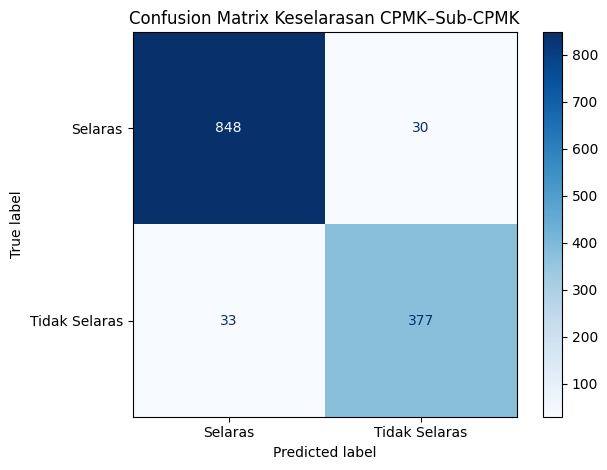

In [19]:
y_true = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

y_pred = df["pred_keselarasan"]



labels = ["Selaras", "Tidak Selaras"]

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix Keselarasan CPMK–Sub-CPMK")
plt.tight_layout()
plt.show()

# LGBM

## Libraries for LGBM

### Import Libraries

In [20]:
import pandas as pd
import re
import joblib
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from lightgbm import LGBMClassifier

### Preprocessing Dataset

In [21]:
df = pd.read_csv("/content/learning_outcomes.csv")

df["Learning_Outcome"] = df["Learning_Outcome"].astype(str).apply(clean_text)

In [22]:
X = df["Learning_Outcome"]
y_raw = df["Level"]

le = LabelEncoder()
y = le.fit_transform(y_raw)

In [23]:
le = LabelEncoder()
y = le.fit_transform(y_raw)



### Training

#### Pipeline

In [24]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("lgbm", LGBMClassifier(
        objective="multiclass",
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

In [25]:
# cv = StratifiedKFold(
#     n_splits=5,
#     shuffle=True,
#     random_state=42
# )

In [26]:
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],

    "lgbm__learning_rate": [0.05, 0.1],
    "lgbm__num_leaves": [31, 63],
    "lgbm__max_depth": [-1, 10]
}

In [27]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3984
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 187
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057
[LightGBM] [Info] Start training from score -2.639057

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       n_jobs=-1,
                                                       objective='multiclass',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.05, 0.1],
                         'lgbm__max_depth': [-1, 10],
                         'lgbm__num_leaves': [31, 63],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

### Evaluation

Classification-Report - Train

In [30]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_train)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_train, y_pred))
print(
    classification_report(
        y_train,
        y_pred,
        target_names=le.classes_
    )
)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Params: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__num_leaves': 31, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.9844660194174757
              precision    recall  f1-score   support

          A2       1.00      1.00      1.00         2
          A3       1.00      1.00      1.00         4
          A4       0.89      0.95      0.92        62
          A5       0.89      1.00      0.94        62
          C1       0.99      1.00      0.99        70
          C2       1.00      0.98      0.99       393
          C3       0.98      0.99      0.99       233
          C4       0.99      0.99      0.99       390
          C5       0.99      0.99      0.99       169
          C6       1.00      0.99      0.99       373
          P2       1.00      1.00      1.00        23
          P3       0.99      0.96      0.97       179
          P4       0.96      1.00      0.98        82
          P5       1.00      1.00      1.00        18

    accuracy        

In [31]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_train)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_train, y_pred))
print(
    classification_report(
        y_train,
        y_pred,
        target_names=le.classes_
    )
)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Params: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__num_leaves': 31, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.9844660194174757
              precision    recall  f1-score   support

          A2       1.00      1.00      1.00         2
          A3       1.00      1.00      1.00         4
          A4       0.89      0.95      0.92        62
          A5       0.89      1.00      0.94        62
          C1       0.99      1.00      0.99        70
          C2       1.00      0.98      0.99       393
          C3       0.98      0.99      0.99       233
          C4       0.99      0.99      0.99       390
          C5       0.99      0.99      0.99       169
          C6       1.00      0.99      0.99       373
          P2       1.00      1.00      1.00        23
          P3       0.99      0.96      0.97       179
          P4       0.96      1.00      0.98        82
          P5       1.00      1.00      1.00        18

    accuracy        

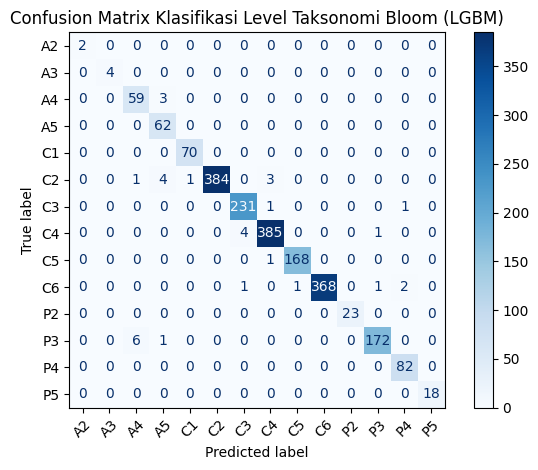

In [33]:
labels = sorted(y_train.unique(), key=lambda x: (x[0], int(x[1:])))
cm = confusion_matrix(
    y_train,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    cmap="Blues",
    values_format="d",
    xticks_rotation=45
)

plt.title("Confusion Matrix Klasifikasi Level Taksonomi Bloom (LGBM)")
plt.tight_layout()
plt.show()

#### Classification-Report - Val

In [34]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(
    classification_report(
        y_test,
        y_pred,
        target_names=le.classes_
    )
)


Best Params: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__num_leaves': 31, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.7655038759689923
              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         1
          A3       0.00      0.00      0.00         1
          A4       0.44      0.44      0.44        16
          A5       0.61      0.73      0.67        15
          C1       0.75      0.88      0.81        17
          C2       0.86      0.87      0.86        98
          C3       0.70      0.66      0.68        59
          C4       0.75      0.85      0.80        98
          C5       0.82      0.74      0.78        42
          C6       0.90      0.87      0.89        93
          P2       1.00      0.33      0.50         6
          P3       0.61      0.67      0.64        45
          P4       0.67      0.48      0.56        21
          P5       0.50      0.25      0.33         4

    accuracy        

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

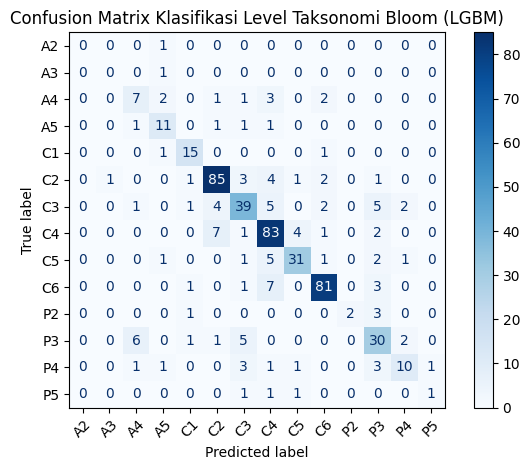

In [35]:
labels = sorted(y_test.unique(), key=lambda x: (x[0], int(x[1:])))
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    cmap="Blues",
    values_format="d",
    xticks_rotation=45
)

plt.title("Confusion Matrix Klasifikasi Level Taksonomi Bloom (LGBM)")
plt.tight_layout()
plt.show()

#### Save-Model

In [36]:

joblib.dump(best_model, "lgbm_bloom_multidomain.pkl")
joblib.dump(le, "label_encoder_bloom.pkl")

['label_encoder_bloom.pkl']

In [39]:
model = joblib.load("/content/lgbm_bloom_multidomain.pkl")
le = joblib.load("/content/label_encoder_bloom.pkl")
df = pd.read_csv("cpmk_subcpmk_pairs.csv")

In [46]:
pred_num_cpmk = model.predict(df["cpmk"].astype(str))
pred_num_sub  = model.predict(df["subcpmk"].astype(str))

print(pred_num_cpmk[:20])  # HARUS ANGKA

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


['C6' 'C6' 'C6' 'C6' 'C6' 'C2' 'C2' 'C3' 'C3' 'C3' 'C3' 'P5' 'P5' 'P5'
 'C6' 'C6' 'C3' 'C3' 'C3' 'C3']


In [42]:
df["pred_level_cpmk"] = model.predict(df["cpmk"].astype(str))


df["pred_level_subcpmk"] =  model.predict(df["subcpmk"].astype(str))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [43]:
def parse_level(label):
    if not isinstance(label, str) or len(label) < 2:
        return None, None
    return label[0], int(label[1:])

In [44]:
def check_alignment(row):
    dom_c, lvl_c = parse_level(row["pred_level_cpmk"])
    dom_s, lvl_s = parse_level(row["pred_level_subcpmk"])

    if dom_c is None or dom_s is None:
        return "Tidak Selaras"

    if dom_c != dom_s:
        return "Tidak Selaras"

    if lvl_s <= lvl_c:
        return "Selaras"

    return "Tidak Selaras"


df["pred_keselarasan"] = df.apply(check_alignment, axis=1)

In [45]:
print("\n=== Alignment Evaluation ===")
print(pd.crosstab(
    df["keselarasan"],
    df["pred_keselarasan"],
    rownames=["Actual"],
    colnames=["Predicted"]
))

df["keselarasan_str"] = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

# Prediction already string
df["pred_keselarasan_str"] = df["pred_keselarasan"]


y_true = df["keselarasan_str"]
y_pred = df["pred_keselarasan_str"]

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"\nAccuracy Score:  {acc:.2%}% \nF-1 Score: {f1:.2f}")
print(classification_report(y_true, y_pred))


=== Alignment Evaluation ===
Predicted  Selaras  Tidak Selaras
Actual                           
False           25            385
True           826             52

Accuracy Score:  94.02%% 
F-1 Score: 0.93
               precision    recall  f1-score   support

      Selaras       0.97      0.94      0.96       878
Tidak Selaras       0.88      0.94      0.91       410

     accuracy                           0.94      1288
    macro avg       0.93      0.94      0.93      1288
 weighted avg       0.94      0.94      0.94      1288



In [ ]:

y_true = df["keselarasan"].map({
    True: "Selaras",
    False: "Tidak Selaras"
})

y_pred = df["pred_keselarasan"]



labels = ["Selaras", "Tidak Selaras"]

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix Keselarasan CPMK–Sub-CPMK")
plt.tight_layout()
plt.show()